# EM Complete Test 10

Testing for larger N, and using less data (nsims runs).

In [1]:
import numpy as np
import matplotlib.pylab as plt

import os
import sys
sys.path.append('../src/')
from simulate_gillespie import *
from estimate_total_rates import *

from higher_order_structures import Complete

## Setup

In [12]:
## --- Setup --- ##
test_name = "em" # DNM

g_type = "complete"

N = 1000
g = Complete(N)

I0 = 10

nsims = 100
run_gillespie_simulations = True

time_max = 10

# TODO: select betas
# beta1 = 2.4 / N       # pairwise infection rate
# beta2 = 4.4 / (N**2)  # hyperedge contagion rate

# hard case of low beta1 and high beta2
beta1 = 1.1 / N       # pairwise infection rate
beta2 = 8.0 / (N**2)  # hyperedge contagion rate

mu    = 1.0           # recovery rate

print(f"{test_name}: \n") # DNM
print(f"\t H = {g.name}, N = {N}, I0 = {I0}, time_max = {time_max},")
print(f"\t beta1 * N = {beta1 * N}, beta2 * N^2 = {beta2 * (N**2)}, mu = {mu},")
print(f"\t with estimation based on {nsims} Gillespie simulation runs\n")

em: 

	 H = Complete, N = 1000, I0 = 10, time_max = 10,
	 beta1 * N = 1.1, beta2 * N^2 = 8.0, mu = 1.0,
	 with estimation based on 100 Gillespie simulation runs



In [13]:
## --- Run Gillespie ---
# I0_gillespie = I0 # TODO: go over the range when necessary
# initial_infections = list(range(I0_gillespie))
if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        X_t = gillespie_sim_complete(N, beta1, beta2, mu, I0, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed(f'../results/gillespie-sims_{test_name}.npz', **sim_results)
else: 
    # load simulation results
    sim_results = np.load(f'../results/gillespie-sims_{test_name}.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0
break: k = 0


In [14]:
# discretize
t_obs_start = 0.0           # start observation time
t_obs_end = time_max        # end observation time
num_intervals = 100          # number of intervals between observations: 21 points

Y_sequence_all = []
for i, X_t in enumerate(X_sims):
    # extract times and states
    if X_t.shape[0] < 3:
         # skip empty
         continue
    times_run = X_t[0, :].astype(float)
    states_run = X_t[2, :].astype(int)
    Y_sequence_run = discretize_sequence((times_run, states_run), t_obs_start, t_obs_end, num_intervals)
    Y_sequence_all.extend(Y_sequence_run)
    
for i in range(min(5, len(Y_sequence_all))):
    print(f"interval {i}: state {Y_sequence_all[i][0]} - {Y_sequence_all[i][1]} (dt={Y_sequence_all[i][2]})")

interval 0: state 10 - 9 (dt=0.1)
interval 1: state 9 - 11 (dt=0.1)
interval 2: state 11 - 6 (dt=0.1)
interval 3: state 6 - 6 (dt=0.1)
interval 4: state 6 - 5 (dt=0.1)


plot saved to ../figures/estimation/em/gillespie_discrete_N=1000_I0=10_npts=101.pdf


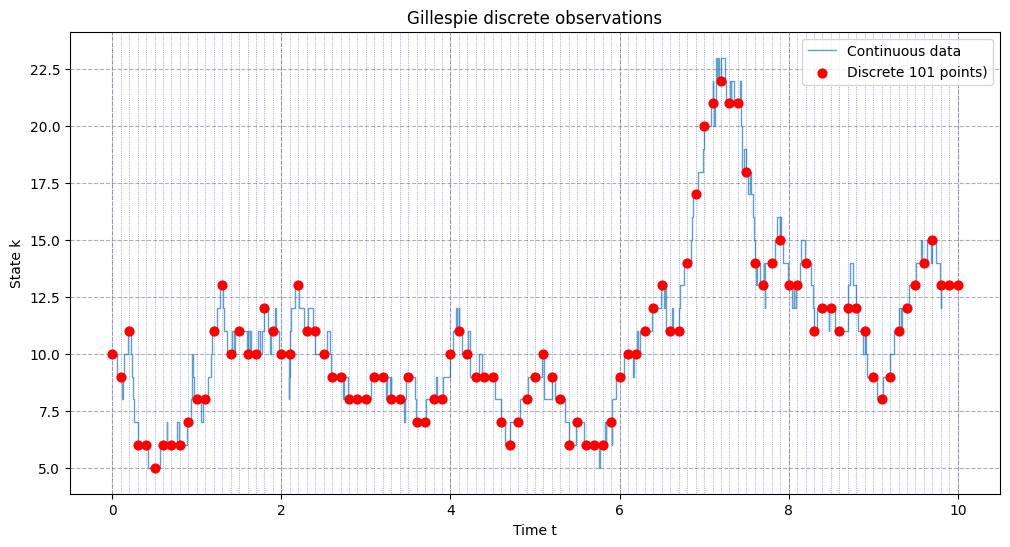

In [15]:
# plot just one example run with discrete points
def plot_discretized_sequence(X_times, X_states, Y_obs_sequence, t_obs_start, t_obs_end, num_intervals):
    plt.figure(figsize=(12, 6))
    plt.step(X_times, X_states, where='post', label='Continuous data', alpha=0.7, linewidth=1.0)

    observation_times = np.linspace(t_obs_start, t_obs_end, num_intervals + 1)
    observed_states_at_times = [Y_obs_sequence[0][0]]
    observed_states_at_times.extend([interval[1] for interval in Y_obs_sequence])

    plt.scatter(observation_times, observed_states_at_times,
                color='red', marker='o', s=40, zorder=5,
                label=f'Discrete {num_intervals + 1} points)')

    for t_obs in observation_times:
        plt.axvline(t_obs, color='blue', linestyle=':', linewidth=0.5, alpha=0.6)

    plt.xlabel("Time t")
    plt.ylabel("State k")
    plt.title("Gillespie discrete observations")
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.xlim(left=min(X_times[0], t_obs_start - (t_obs_end-t_obs_start)*0.05 ))
    
    min_state, max_state = np.min(X_states), np.max(X_states)
    plt.ylim(bottom=min_state - max(1, max_state*0.05), top=max_state + max(1, max_state*0.05))
    
    filename = f"../figures/estimation/{test_name}/gillespie_discrete_N={N}_I0={I0}_npts={num_intervals + 1}.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    print(f"plot saved to {filename}")
    plt.show()

plot_run_index = 0

X_t_plot = X_sims[plot_run_index]
times_plot = X_t_plot[0, :].astype(float)
states_plot = X_t_plot[2, :].astype(int)

Y_sequence_plot = discretize_sequence((times_plot, states_plot), t_obs_start, t_obs_end, num_intervals)
plot_discretized_sequence(times_plot, states_plot, Y_sequence_plot, t_obs_start, t_obs_end, num_intervals)

## Estimate

In [16]:
dt = Y_sequence_all[0][2] # interval duration / step size 
num_intervals = len(Y_sequence_all)

# assuming observations start at 0
t_obs_start = 0.0
t_obs_end = num_intervals * dt

# extract time points and observed states
t_data_bd = np.linspace(t_obs_start, t_obs_end, num_intervals + 1).tolist()
p_data_bd = [Y_sequence_all[0][0]]
p_data_bd.extend([interval[1] for interval in Y_sequence_all])

len(Y_sequence_all)

10000

In [17]:
# TODO: set initial guess \theta^{(0)}

# beta1_guess = beta1
# beta2_guess = beta2

# beta1_guess = beta1 * 0.8
# beta2_guess = beta2 * 1.2

beta1_guess = 1
beta2_guess = 1

p0_guess = [beta1_guess, beta2_guess]

# TODO: set reasonable bounds, these are quite high now
max_beta1 = 10.0
max_beta2 = 50.0
p_bounds = [[1e-9, max_beta1], [1e-9, max_beta2]]

In [18]:
# es1 = estimate_em(t_data_bd, p_data_bd, p0_guess, p_bounds)

In [19]:
es2 = estimate_dnm(t_data_bd, p_data_bd, p0_guess, p_bounds)

Estimated parameters [beta1, beta2]: [np.float64(0.7828774289590537), np.float64(10.357383421030699)]
Standard errors: [np.float64(0.052110883288164635), np.float64(0.3010045275052687)]
Log-likelihood: -110003.56555488205
Compute time: 324 seconds


In [10]:
I0

50